In [1]:
from pathlib import Path
import numpy as np

import matplotlib as mpl
from matplotlib import pyplot as plt

import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn import CrossEntropyLoss
from torch.nn.functional import log_softmax, softmax

from library.nn_training import train_and_eval, select_device
from library.plotting import setup_high_quality_mpl_params, plot_loss_curves, make_plot_note
from library.datasets import Aggregated_Signal_Binned_Dataset, Bag_Signal_Binned_Dataset, Bootstrapped_Signal_Binned_Dataset
from library.util import bootstrap_over_bins

device = select_device()

setup_high_quality_mpl_params()

Device:  cuda


In [2]:
def predict_log_likelihood(x, model):
    model.eval()
    with torch.no_grad():
        unnormalized_log_likelihood = model(x)
    return unnormalized_log_likelihood

In [3]:
regenerate = False

level = "gen"
save_dir = "../../state/new_physics/data/processed"
raw_signal_dir = "../../state/new_physics/data/raw/signal"

num_events_per_set = 24_000
num_sets_per_label = 1

normalize = True
q_squared_veto = True

datasets = {
    "train": Bootstrapped_Signal_Binned_Dataset(level=level, split="train", save_dir=save_dir),
    "eval": Bootstrapped_Signal_Binned_Dataset(level=level, split="eval", save_dir=save_dir),
}

if regenerate:
    datasets["train"].generate(
        raw_trials=range(0,20), 
        raw_signal_dir=raw_signal_dir, 
        num_events_per_set=num_events_per_set,
        num_sets_per_label=num_sets_per_label,
        std_scale=normalize, 
        q_squared_veto=q_squared_veto,
    )
    datasets["eval"].generate(
        raw_trials=range(20,30), 
        raw_signal_dir=raw_signal_dir, 
        num_events_per_set=num_events_per_set,
        num_sets_per_label=num_sets_per_label,
        std_scale=normalize, 
        q_squared_veto=q_squared_veto,
    )

datasets["train"].load(device)
datasets["eval"].load(device)

np.testing.assert_equal(datasets["train"].bin_values, datasets["eval"].bin_values)


Loaded data with features size: torch.Size([44, 24000, 4]) and labels size: torch.Size([44]).
Loaded data with features size: torch.Size([44, 24000, 4]) and labels size: torch.Size([44]).


In [4]:
class My_NN(nn.Module):
    def __init__(self, nickname):
        super().__init__()

        self.nickname = nickname

        models_dir = Path("../../state/new_physics/models/")
        self.save_path = models_dir.joinpath(nickname)

        self.base = nn.Sequential(
            nn.Linear(4, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 44),
        )
        
        self.double()

    def forward(self, x):
        unnormalized_log_likelihood = torch.sum(self.base(x), dim=1)        
        return unnormalized_log_likelihood
    


epoch 0 complete:
    Train loss: 3082.78175429011
    Eval loss: 1910.1523675551628

learning rate: [0.003]
peak gpu memory usage: 0.10192 GB

epoch 1 complete:
    Train loss: 1604.0791206911429
    Eval loss: 1086.2124891374117

learning rate: [0.003]
peak gpu memory usage: 0.10192 GB

epoch 2 complete:
    Train loss: 1146.1034789064336
    Eval loss: 732.7266295722173

learning rate: [0.003]
peak gpu memory usage: 0.10192 GB

epoch 3 complete:
    Train loss: 1043.4796746254988
    Eval loss: 653.7828832952174

learning rate: [0.003]
peak gpu memory usage: 0.10192 GB

epoch 4 complete:
    Train loss: 954.4574342115262
    Eval loss: 490.8722097997541

learning rate: [0.003]
peak gpu memory usage: 0.10192 GB

epoch 5 complete:
    Train loss: 727.8230168952977
    Eval loss: 572.4478385243649

learning rate: [0.003]
peak gpu memory usage: 0.10192 GB

epoch 6 complete:
    Train loss: 717.6886634070179
    Eval loss: 533.9692638419854

learning rate: [0.003]
peak gpu memory usage:

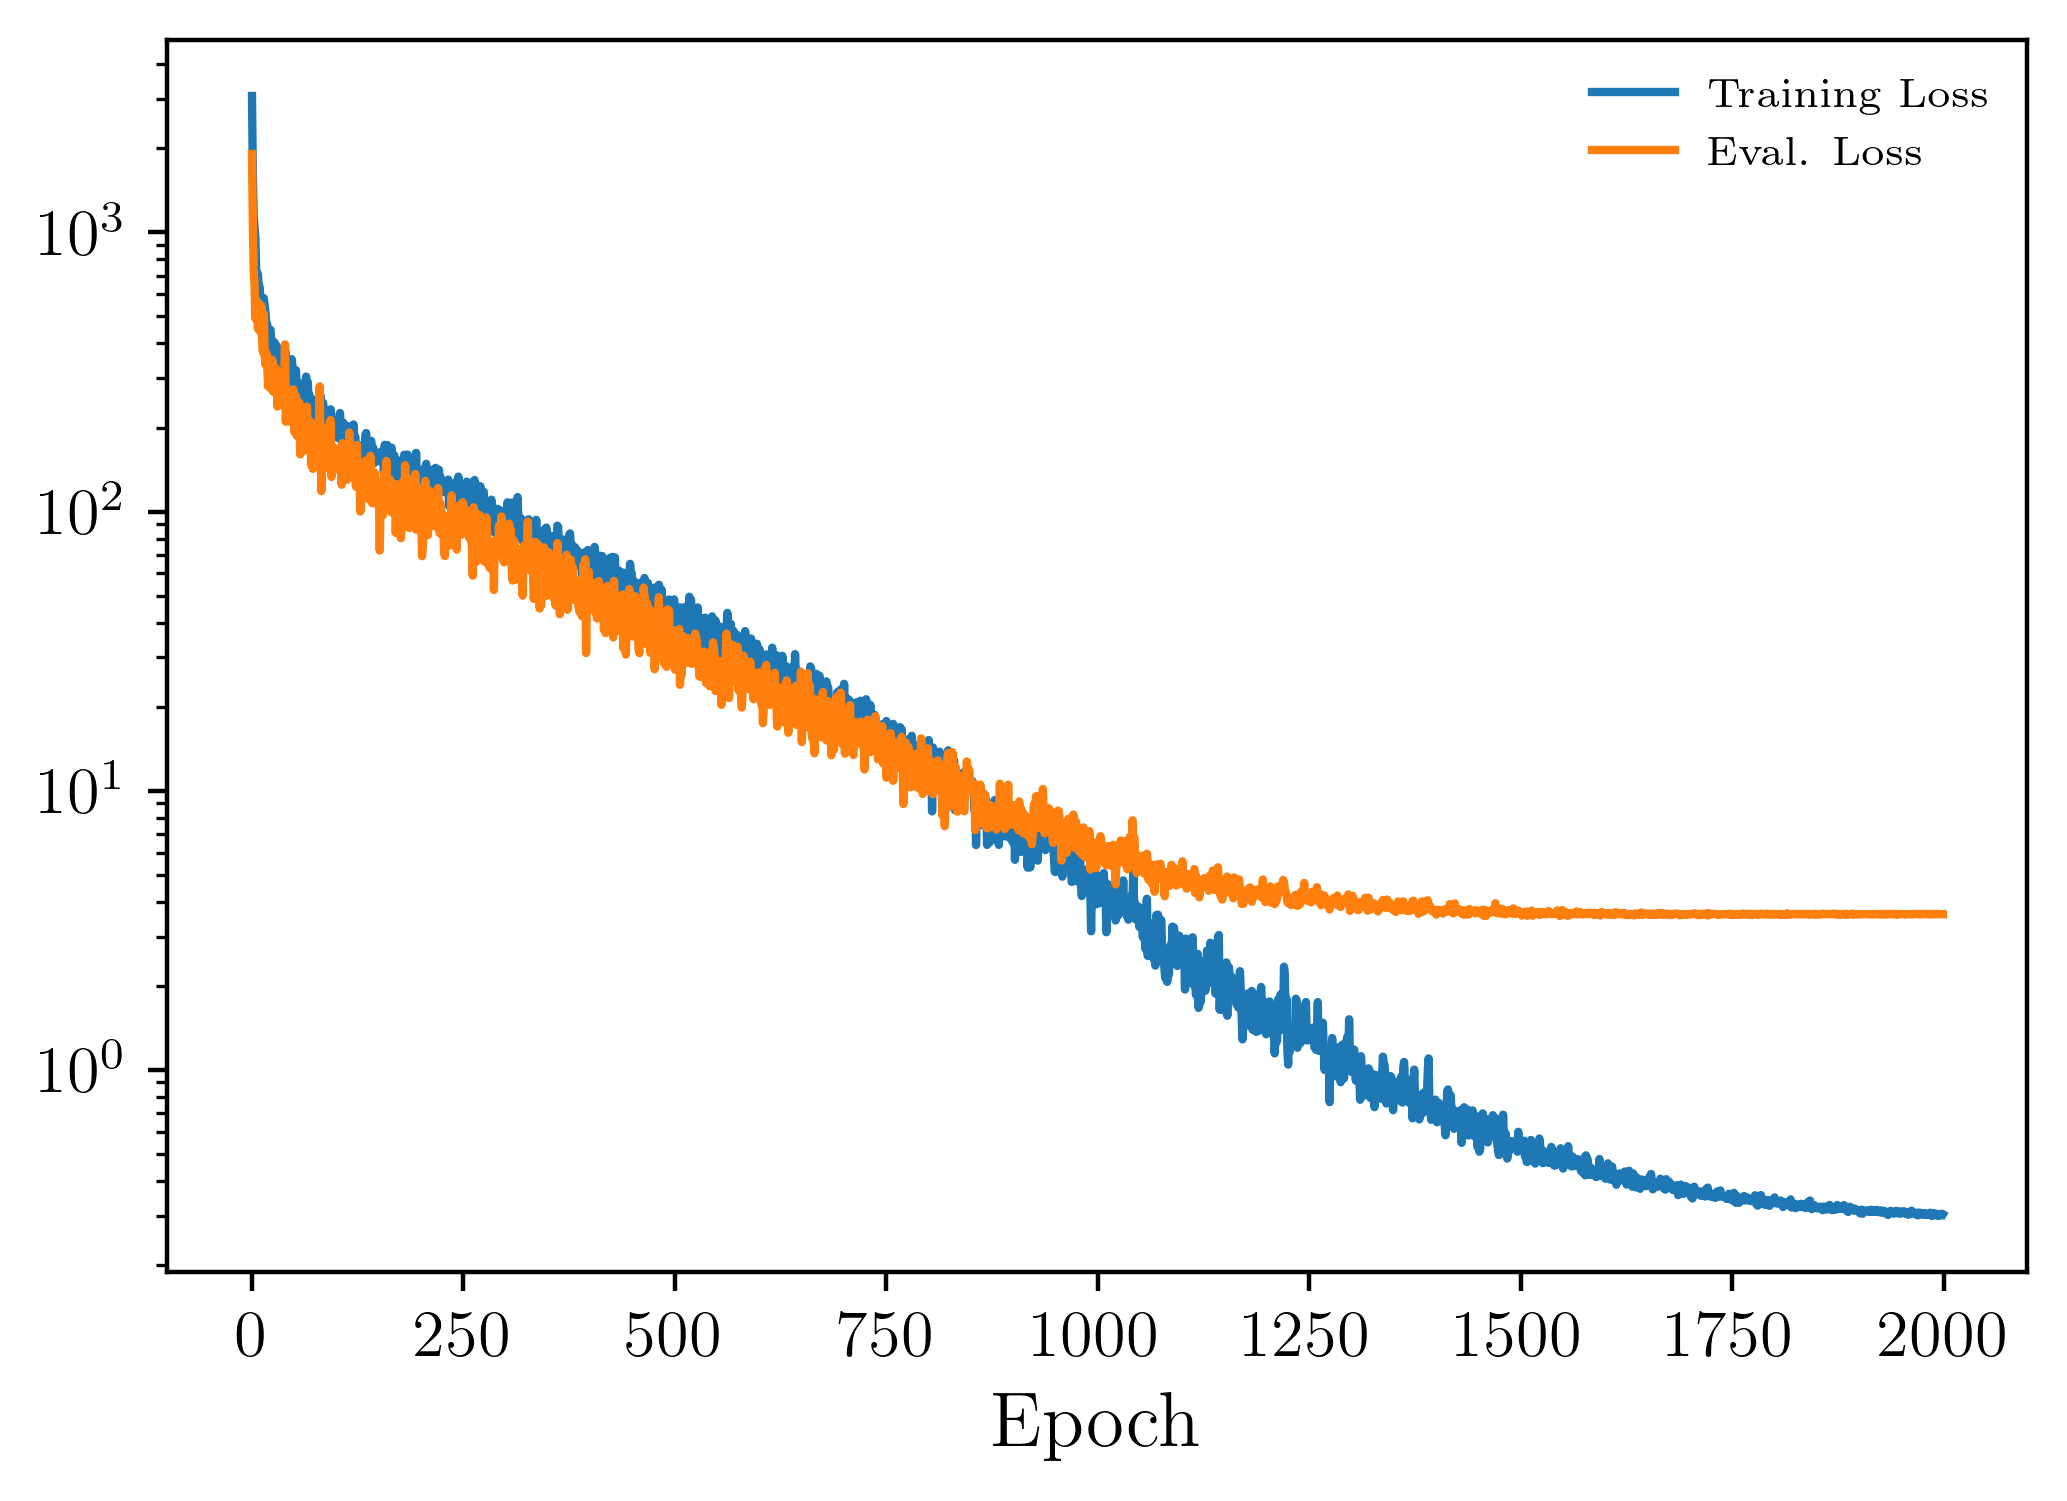

In [5]:
retrain = True

model = My_NN("test_4000")

if retrain:
    learning_rate = 3e-3
    epochs = 2_000
    train_batch_size = 1
    eval_batch_size = 1
    loss_fn = CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)
    scheduler = ReduceLROnPlateau(optimizer, factor=0.95)

    loss_table = train_and_eval(
        model, 
        datasets["train"], datasets["eval"], 
        loss_fn, optimizer, 
        epochs, 
        train_batch_size, eval_batch_size, 
        device, 
        move_data=False,
        scheduler=scheduler,
    )
    torch.save(model.state_dict(), model.save_path)
    _, ax = plt.subplots()
    plot_loss_curves(loss_table["epoch"], loss_table["train_loss"], loss_table["eval_loss"], ax)
    ax.set_yscale("log")
    plt.show()
else:
    model.load_state_dict(torch.load(model.save_path, weights_only=True))
    model.to(device)

In [6]:
unnormalized_log_likelihoods = predict_log_likelihood(datasets["eval"].features, model)

In [ ]:
unnormalized_log_likelihoods

In [8]:
normalized_log_likelihoods = log_softmax(unnormalized_log_likelihoods, dim=1)

In [ ]:
normalized_log_likelihoods

Text(0, 0.5, '$\\log p(\\delta C_9 | x_1, ..., x_N)$')

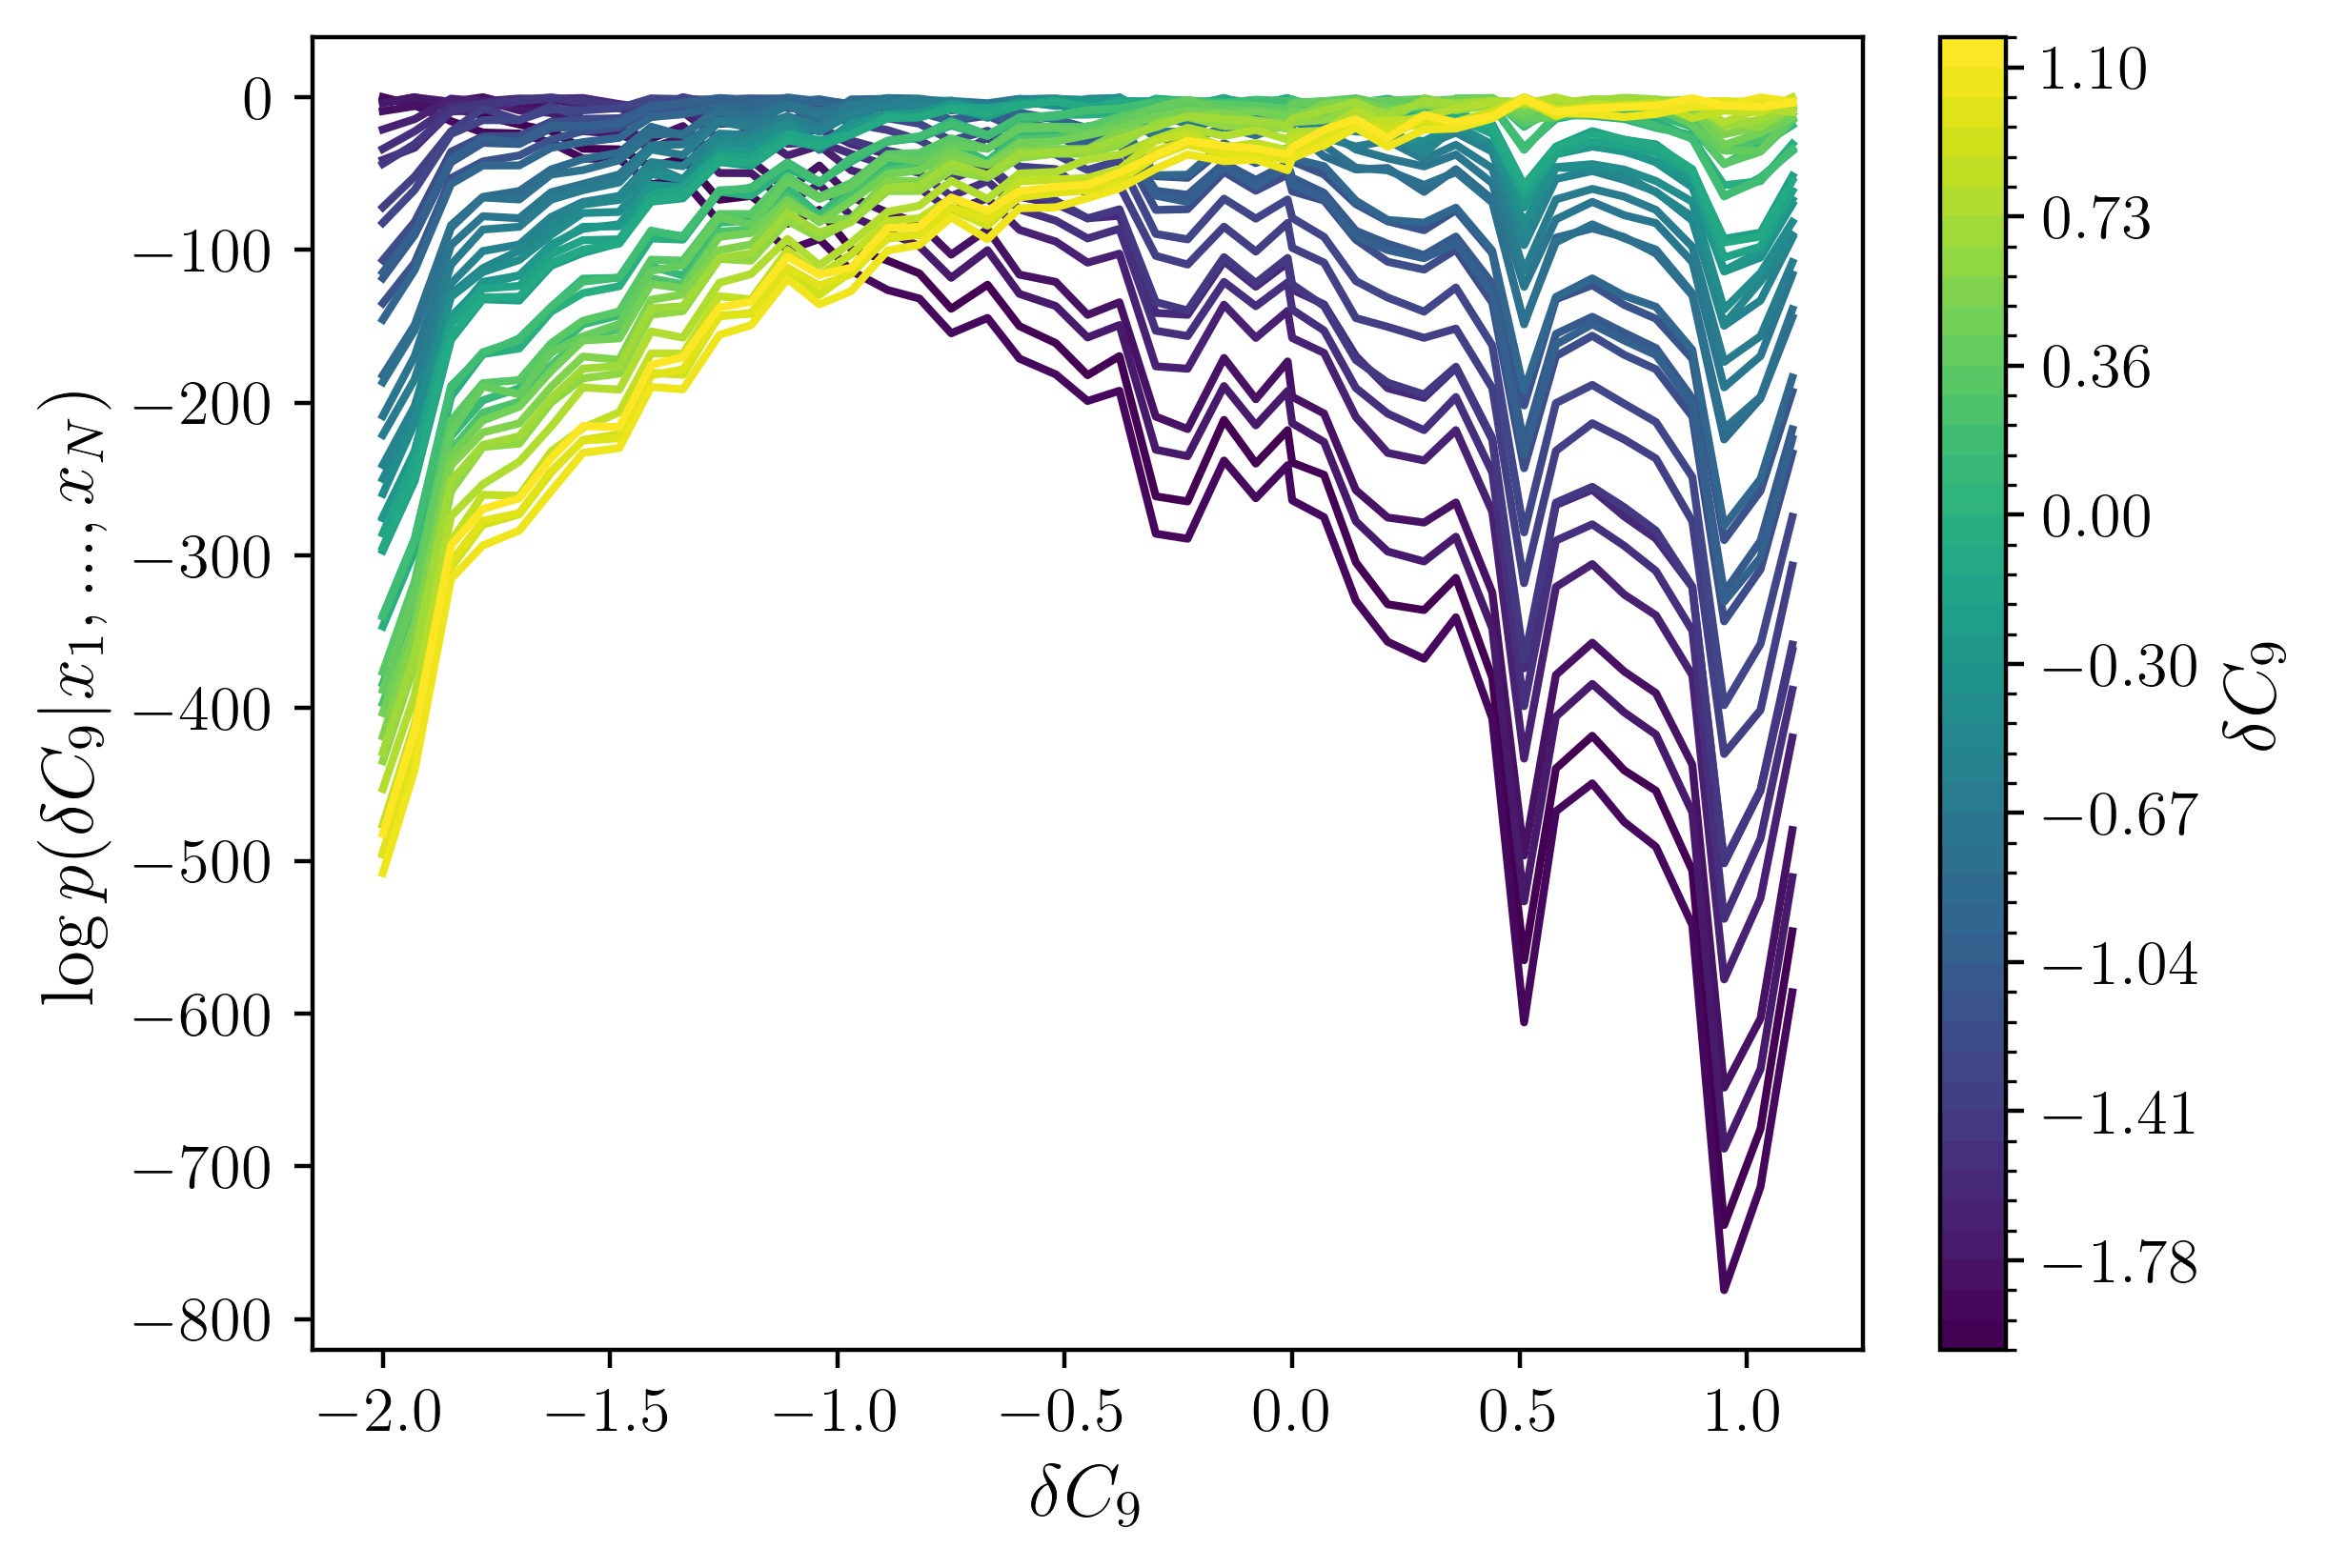

In [7]:
unnormalized_log_likelihoods = predict_log_likelihood(datasets["eval"].features[:,:,:], model)
normalized_log_likelihoods = log_softmax(unnormalized_log_likelihoods, dim=1)

fig, ax = plt.subplots(layout="constrained")

bin_values = datasets["eval"].bin_values

cmap = plt.cm.viridis

bounds = np.append(bin_values, bin_values[-1] + (bin_values[-1] - bin_values[-2]))
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

for value, curve in zip(bin_values, normalized_log_likelihoods.cpu()):
    ax.plot(bin_values, curve, color=cmap(norm(value)))

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, label=r"$\delta C_9$")
ax.set_xlabel(r"$\delta C_9$")
ax.set_ylabel(r"$\log p(\delta C_9 | x_1, ..., x_N)$")




In [ ]:
datasets["eval"].labels

In [ ]:
unnormalized_log_likelihoods = predict_log_likelihood(datasets["train"].features, model)
normalized_log_likelihoods = log_softmax(unnormalized_log_likelihoods, dim=1)
for curve in normalized_log_likelihoods[::1].cpu():
    plt.plot(curve)
plt.show()
